In [361]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0, j1, jv, i0
from scipy.special import jn_zeros
from scipy.integrate import quad
from scipy.integrate import dblquad
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

## Constants and math functions

In [362]:
H = 10.0 
R = 5.0 

z = np.linspace(0, H, 50)
r = np.linspace(0, R, 50)

max_k = 5
max_n = 5


In [363]:
def I0(x):
    return i0(x)

def J0(x):
    return j0(x)

def J1(x):
    return j1(x)

def J2(x):
    return jv(2, x)

def find_beta_k_roots(max_k, R=1):
    # Находим первые max_k нулей функции Бесселя первого порядка J1
    j1_zeros = jn_zeros(1, max_k)
    # Вычисляем соответствующие β_k = j1_zero / R
    roots = j1_zeros / R
    return roots

In [364]:
mu_0 = 1.0  
alpha = 1.0  

def a_k(k):
    return np.pi*(2 * k + 1) / 2

def lambda_n(n):
    return (np.pi * n) / 2

beta_k = find_beta_k_roots(max_k, R)

## Solutions

### Function $\tau$ of temperature

The solution of the mathematical model of the heat conduction problem
$$
\tau(r, z)=\sum^\infty_0\frac{I_0(a_kr)}{I_0(a_kR)}f_ksin(a_kz)
$$
Where
$$ 
f_k=\int^H_0f(z)sin(a_kz)dz 
$$

In [365]:
def f(z):
    return -z**2+H*z

def f_k(k):
    integrand = lambda z: f(z) * np.sin(a_k(k) * z)
    integral = quad(integrand, 0, H)[0]
    return integral

In [366]:
f_k_array = np.empty(max_k)
for k in range(1, max_k+1):
    result = f_k(k)
    f_k_array[k-1] = result 

1
2
3
4
5


In [367]:
def tau(r, z, max_k):
    sum= 0.0
    for k in range(0, max_k + 1):
        ak = a_k(k)
        sum += (f_k_array[k-1] / I0(ak * R)) * I0(ak * r) * np.sin(ak * z)
    return (2 / H) * sum

$$
\tau_{nk}=\int^R_0J_0(\beta_kr)rdr\int^H_0\tau(r,z)cos(\lambda_nz)dz \\
\lambda_n=\frac{\pi n}{2},\ \ n=0,1,... \\
\beta_k\text{ - solutions of the equation: } J_0(\beta_kR)=0 
$$

In [368]:
def tau_nk(n, k, tau_func, max_k):
    """
    Возвращает двойной интеграл
        ∫_{r=0}^R ∫_{z=0}^H tau(r,z) * J0(beta_k[k] * r) * r * cos(lambda_n(n) * z) dz dr
    """
    # Функция для dblquad: первый аргумент — z, второй — r
    def integrand(z, r):
        return tau_func(r, z, max_k) * j0(beta_k[k-1]) * r * np.cos(lambda_n(n) * z)

    # dblquad ожидает порядок: dblquad(func, r_min, r_max, z_min_fun, z_max_fun)
    result, error = dblquad(integrand,
                            0,     # r от 0
                            R,     # до R
                            lambda r: 0,  # для каждого r, z от 0
                            lambda r: H)  # до H
    return result

In [369]:
tau_nk_array = np.empty([max_n, max_k])
for n in range(1, max_n+1):
    for k in range(1, max_k+1):
        result = tau_nk(n, k, tau, max_k)
        print(n, k)
        tau_nk_array[n-1, k-1] = result
print(tau_nk_array)

1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5
[[-7.77489249e-18 -5.52509817e-18 -2.09370484e-18  1.11830810e-18
   3.39774347e-18]
 [ 5.37106082e-03  3.53593196e-03  1.27584070e-03 -7.92628152e-04
  -2.14592249e-03]
 [ 2.10485997e-17  1.33043755e-17  5.11455237e-18 -3.22787302e-18
  -8.62531073e-18]
 [-3.03865259e-03 -2.00043700e-03 -7.21800919e-04  4.48425677e-04
   1.21404563e-03]
 [ 5.38944834e-18  3.73621287e-18  1.29353804e-18 -7.74539058e-19
  -2.34093245e-18]]


### Functions $u(r, z)$ and $w(r, z)$

$$
u(r,z)=\frac{4\mu_0\alpha}{HR^2}
\left(\sum_{k=1}^\infty \frac{1}{\beta_k} \frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}\tau_{0k}
+2\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{k=1}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} 
cos(\lambda_nz)\right)\tau_{nk}
$$

In [370]:
def u(r, z, max_k, max_n):
    sum_u = 0.0
    for k in range(1, max_k + 1):
        sum_u += (1 / beta_k[k-1]) * J1(beta_k[k-1] * r) * J0(k * r) * tau_nk_array[0, k-1]
    for n in range(1, max_n + 1):
        for k in range(1, max_k + 1):
            sum_u += 2 * (J1(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2) * (beta_k[k-1] / (beta_k[k-1]**2 + lambda_n(n)**2)) * np.cos(lambda_n(n) * z) * tau_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u

$$
w(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{0k}r)}{J_0^2(\beta_{0k}R)}
\sum_{n=1}^\infty \frac{\lambda_n}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)\tau_{nk}
$$

In [371]:
def w(r, z, max_k, max_n):
    sum_w = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w += (J0(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2) * (lambda_n(n) / (beta_k[k-1]**2 + lambda_n(n)**2)) * np.sin(lambda_n(n) * z) * tau_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w

### Partial derivative's $u(r, z)$

$$
\frac{\partial u}{\partial r}(r,z)
=\frac{4\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{k}r)-J_2(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=0}^\infty \frac{\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} 
cos(\lambda_nz)\tau_{nk}
$$

In [372]:
def partial_u_r(r, z, max_k, max_n):
    sum_u_r = 0.0
    for k in range(1, max_k + 1):
        for n in range(0, max_n + 1):
            sum_u_r += (J0(beta_k[k-1] * r) - J2(beta_k[k-1] * r)) / J0(beta_k[k-1] * R)**2 * (beta_k[k-1] / (beta_k[k-1]**2 + lambda_n(n)**2)) * np.cos(lambda_n(n) * z) * tau_nk_array[n-1, k-1]
    return (4 * mu_0 * alpha) / (H * R**2) * sum_u_r

$$
\frac{\partial u}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda_n\beta_k}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)\tau_{nk}
$$

In [373]:
def partial_u_z(r, z, max_k, max_n):
    sum_u_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_u_z += J1(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2 * (lambda_n(n) * beta_k[k-1] / (beta_k[k-1]**2 + lambda_n(n)**2)) * np.sin(lambda_n(n) * z)  * tau_nk_array[n-1, k-1]
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_u_z

### Partial derivative's $w(r, z)$

$$
\frac{\partial w}{\partial r}(r,z)
=\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_1(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda_n}{\left(\beta^2_k+\lambda^2_n\right)} sin(\lambda_nz)\tau_{nk}
$$

In [374]:
def partial_w_r(r, z, max_k, max_n):
    sum_w_r = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w_r += J1(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2 * (lambda_n(n) / (beta_k[k-1]**2 + lambda_n(n)**2)) * np.sin(lambda_n(n) * z) * tau_nk(n, k, tau, max_k)
    return (8 * mu_0 * alpha) / (H * R**2) * sum_w_r

$$
\frac{\partial w}{\partial z}(r,z)
=-\frac{8\mu_0\alpha}{HR^2}
\sum_{k=1}^{\infty}\frac{J_0(\beta_{k}r)}{J_0^2(\beta_{k}R)}
\sum_{n=1}^\infty \frac{\lambda^2_n}{\left(\beta^2_k+\lambda^2_n\right)} cos(\lambda_nz)\tau_{nk}
$$

In [375]:
def partial_w_z(r, z, max_k, max_n):
    sum_w_z = 0.0
    for k in range(1, max_k + 1):
        for n in range(1, max_n + 1):
            sum_w_z += J0(beta_k[k-1] * r) / J0(beta_k[k-1] * R)**2 * (lambda_n(n)**2 / (beta_k[k-1]**2 + lambda_n(n)**2)) * np.cos(lambda_n(n) * z) * tau_nk(n, k, tau, max_k)
    return (-8 * mu_0 * alpha) / (H * R**2) * sum_w_z

## Check and plot boundary conditions

$$w(r, 0)=0$$

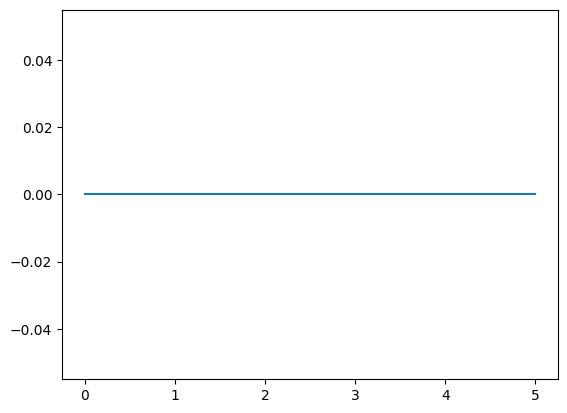

In [376]:
plt.plot(r, w(r, 0, max_k, max_n))

$$\frac{\partial u}{\partial z}|_{z=0}=0$$

(-10.0, 10.0)

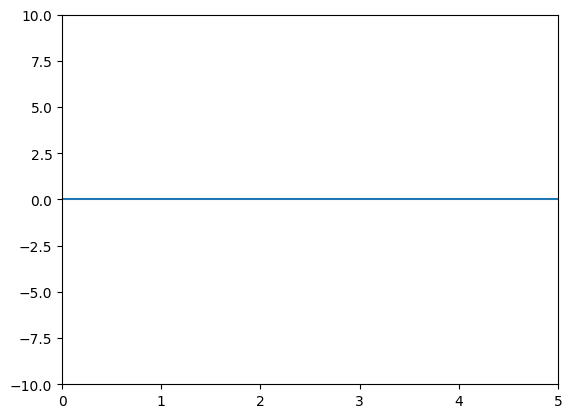

In [391]:
plt.plot(r, partial_u_z(r, 0, max_k, max_n))
plt.xlim(0, R)
plt.ylim(-10, 10)

$$w(r, H)=0$$

(-10.0, 10.0)

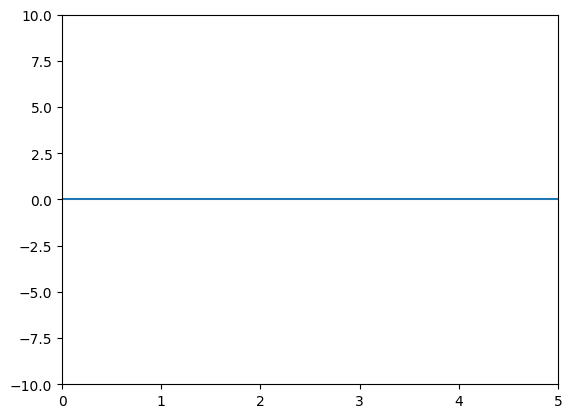

In [385]:
plt.plot(r, w(r, H, max_k, max_n))
plt.xlim(0, R)
plt.ylim(-10, 10)

$$\frac{\partial u}{\partial z}|_{z=H}=0$$

(-10.0, 10.0)

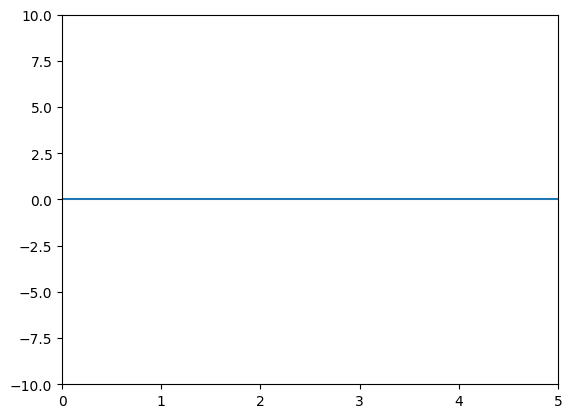

In [390]:
plt.plot(r, partial_u_z(r, H, max_k, max_n))
plt.xlim(0, R)
plt.ylim(-10, 10)

$$u(R, z)=0$$

(-10.0, 10.0)

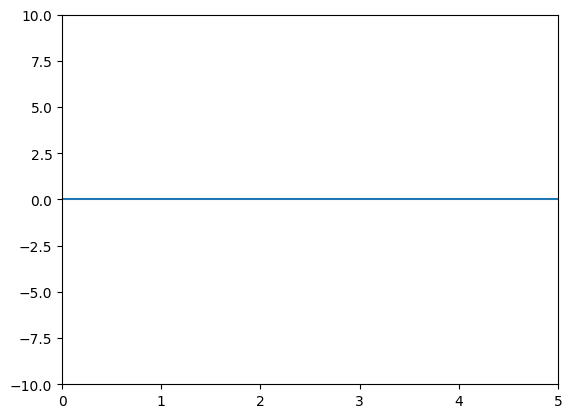

In [ ]:
plt.plot(r, u(R, z, max_k, max_n))
plt.xlim(0, R)
plt.ylim(-10, 10)

$$\frac{\partial w}{\partial r}|_{r=R}=0$$

(-10.0, 10.0)

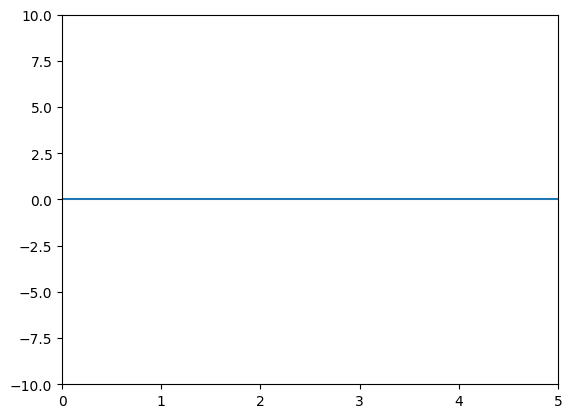

In [386]:
plt.plot(r, partial_w_r(R, z, max_k, max_n))
plt.xlim(0, R)
plt.ylim(-10, 10)

## Cylinder's visualization

In [379]:
def draw_cylinder(colors=['red', 'blue', 'blue'] ,radius=1, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для боковой поверхности
    theta = np.linspace(0, 2 * np.pi, resolution)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z_bottom = np.zeros_like(x)
    z_top = np.ones_like(x) * height
    
    # Рисуем боковую поверхность
    for i in range(len(x) - 1):
        verts = [[(x[i], y[i], z_bottom[i]),
                  (x[i+1], y[i+1], z_bottom[i+1]),
                  (x[i+1], y[i+1], z_top[i+1]),
                  (x[i], y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color=colors[0], edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_bottom))], color=colors[1], edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(x, y, z_top))], color=colors[2], edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-radius, radius])
    ax.set_ylim([-radius, radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / radius])
    
    plt.show()

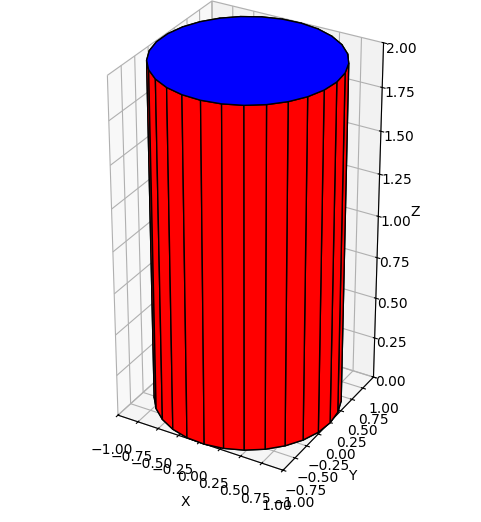

In [381]:
draw_cylinder()

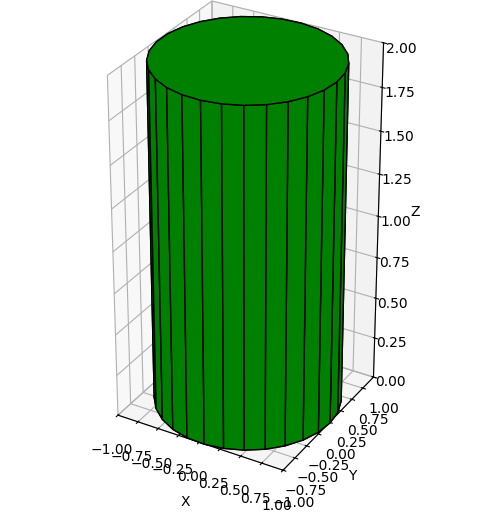

In [382]:
draw_cylinder(['green', 'green', 'green'])

In [380]:
def draw_pol_cylinder(outer_radius=1, inner_radius=0.7, height=2, resolution=30):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Генерация координат для внешней и внутренней боковых поверхностей
    theta = np.linspace(0, 2 * np.pi, resolution)
    outer_x = outer_radius * np.cos(theta)
    outer_y = outer_radius * np.sin(theta)
    inner_x = inner_radius * np.cos(theta)
    inner_y = inner_radius * np.sin(theta)
    z_bottom = np.zeros_like(outer_x)
    z_top = np.ones_like(outer_x) * height
    
    # Рисуем внешнюю боковую поверхность
    for i in range(len(outer_x) - 1):
        verts = [[(outer_x[i], outer_y[i], z_bottom[i]),
                  (outer_x[i+1], outer_y[i+1], z_bottom[i+1]),
                  (outer_x[i+1], outer_y[i+1], z_top[i+1]),
                  (outer_x[i], outer_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем внутреннюю боковую поверхность
    for i in range(len(inner_x) - 1):
        verts = [[(inner_x[i], inner_y[i], z_bottom[i]),
                  (inner_x[i+1], inner_y[i+1], z_bottom[i+1]),
                  (inner_x[i+1], inner_y[i+1], z_top[i+1]),
                  (inner_x[i], inner_y[i], z_top[i])]]
        ax.add_collection3d(Poly3DCollection(verts, color='green', edgecolor='k'))
    
    # Рисуем верхнюю и нижнюю крышки как кольца
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_bottom)) + list(zip(inner_x[::-1], inner_y[::-1], z_bottom))], color='green', edgecolor='k'))
    ax.add_collection3d(Poly3DCollection([list(zip(outer_x, outer_y, z_top)) + list(zip(inner_x[::-1], inner_y[::-1], z_top))], color='green', edgecolor='k'))
    
    # Настройки осей
    ax.set_xlim([-outer_radius, outer_radius])
    ax.set_ylim([-outer_radius, outer_radius])
    ax.set_zlim([0, height])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, height / outer_radius])
    
    plt.show()


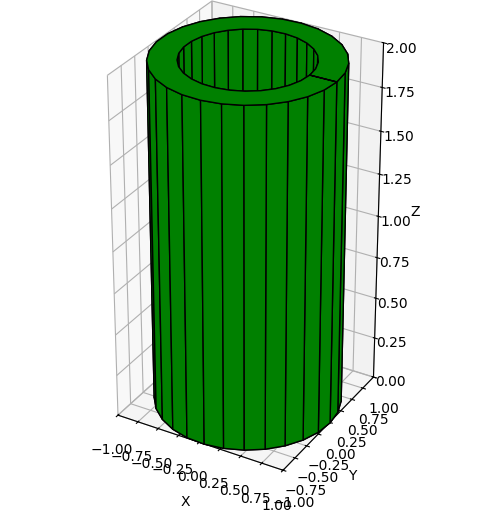

In [383]:
draw_pol_cylinder()